#### Project Headline: 
 ## “What can we learn about the bacterial species that restriction enzymes come from?"
 
Four steps I'm going to show:

First,  how I got & cleaned the data,
 - Python: beautifulsoup
 - R: BacDiveR, BacDiveR.first (my modified version of the package), 
      tidyverse/dplyr

Second, exploratory analysis,
 - R: plotly, wordcloud2

Third, visualization,
 - R: leaflet, ggmap & Google geocoding API 

Fourth, Natural language processing
 - R: tidytext, ggplot2


## REBASE project - Data Collection in Python 

##### Goal: 
- Webscape a list of restriction enzymes from New England Biolabs' enzyme database, http://rebase.neb.com/cgi-bin/eyearlist?2.
- For each of the 11,568 enzymes, extract:
    - enzyme name
    - year of discovery
    - the 6-8bp DNA recognition sequence 
    - enzyme type
    - name of the bacteria (this is inside another html page for each enzyme)
- Store the results in a csv file to analyze in R
    

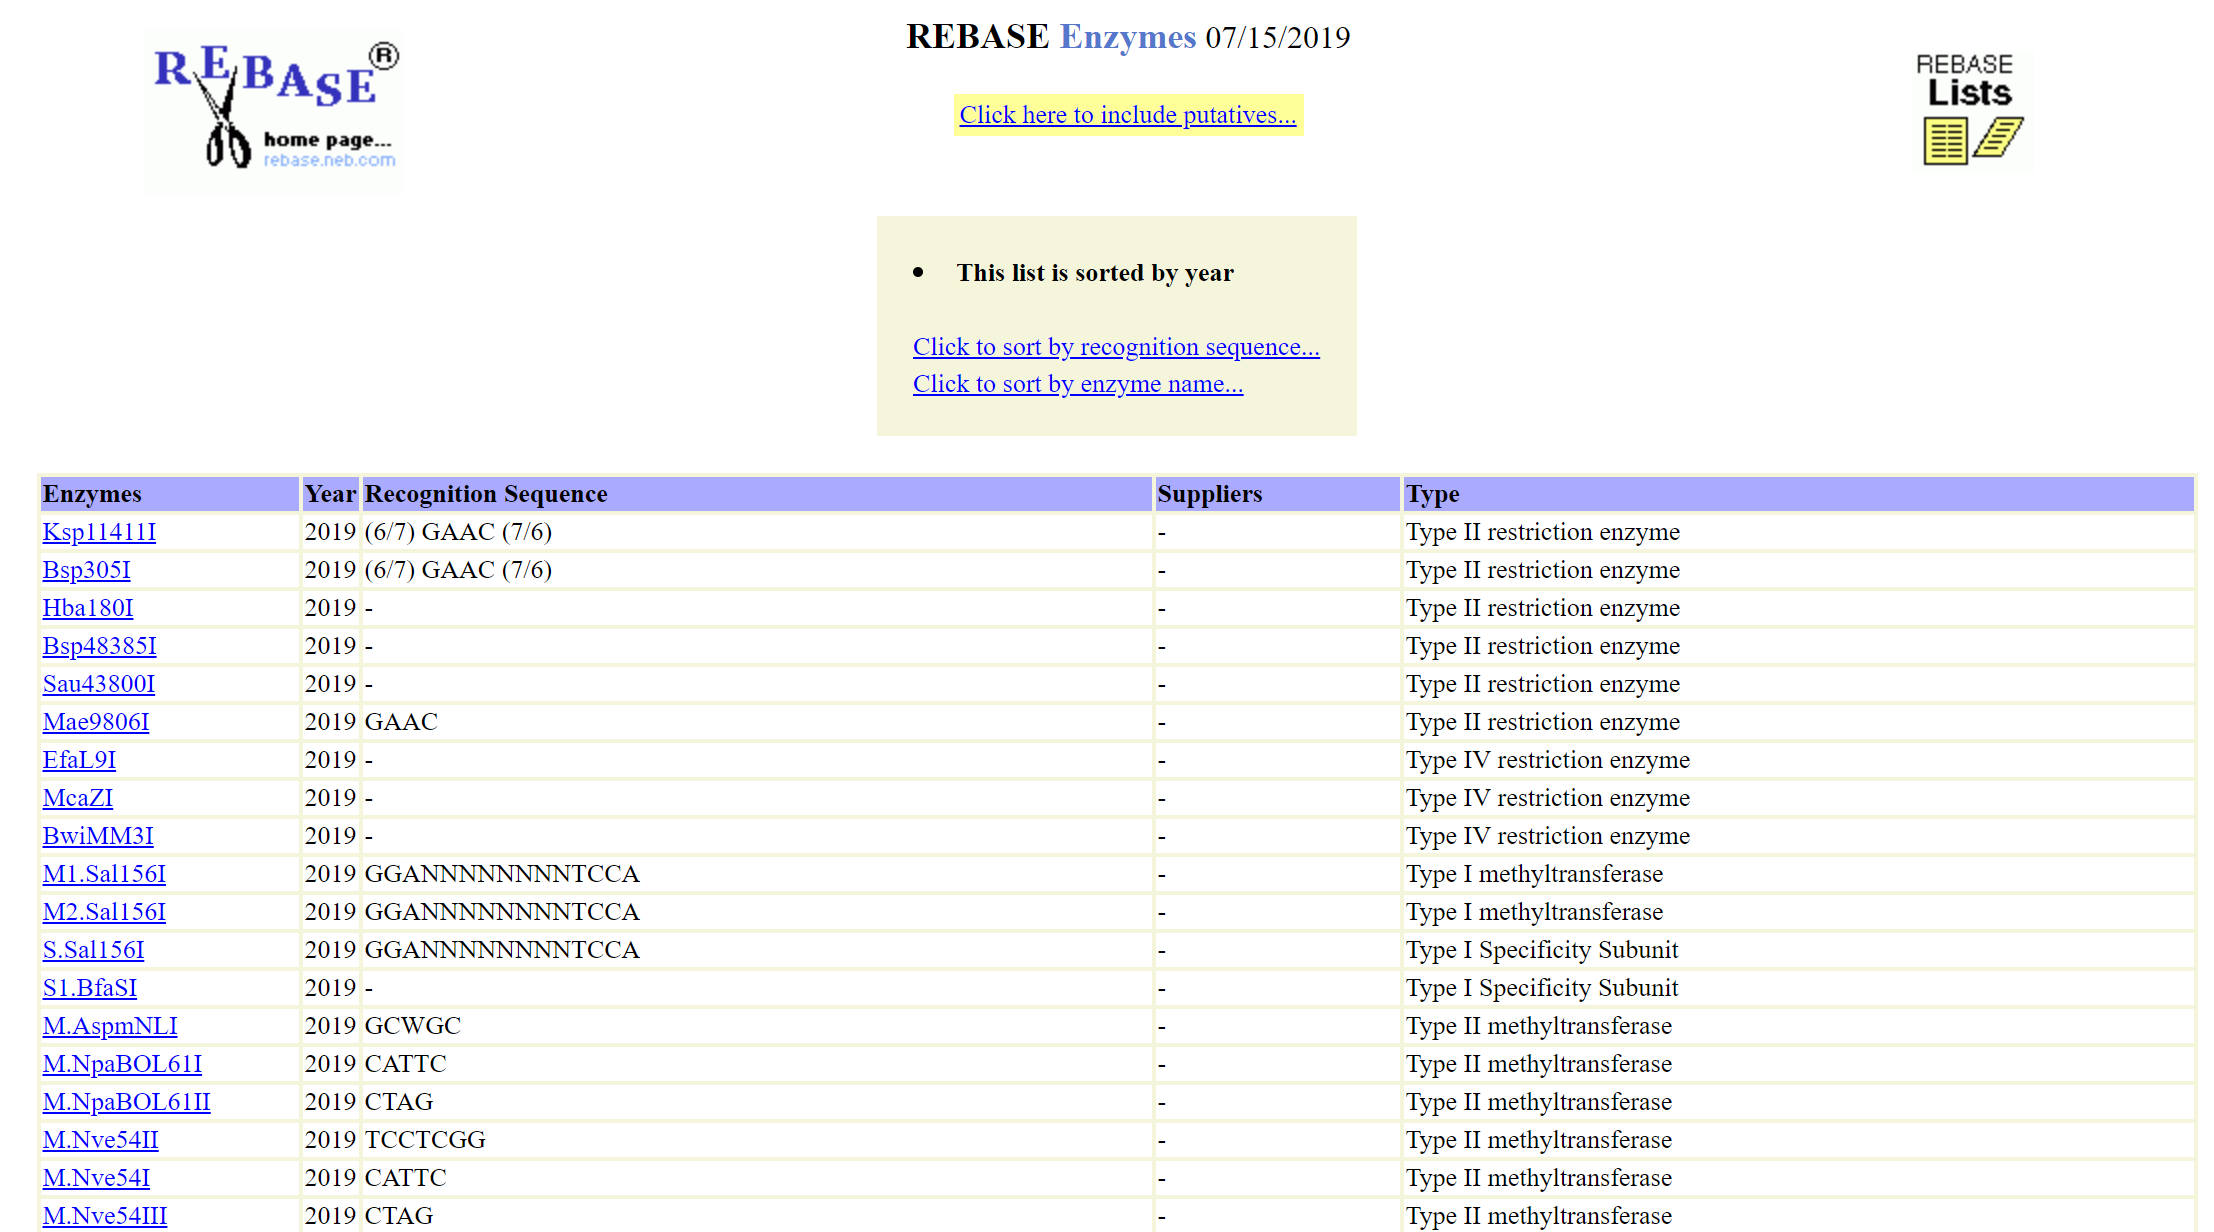

Resources: 

BeautifulSoup Documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/#making-the-soup

MechanicalSoup Documentation: https://mechanicalsoup.readthedocs.io/en/stable/mechanicalsoup.html

https://www.digitalocean.com/community/tutorials/how-to-scrape-web-pages-with-beautiful-soup-and-python-3
https://www.datacamp.com/community/tutorials/web-scraping-using-python
https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
https://docs.python-guide.org/scenarios/scrape/

Python Doc for writerows: https://docs.python.org/2/library/csv.html
https://sopython.com/canon/97/writing-csv-adds-blank-lines-between-rows/

## Setup
This is the link I'll be working with: http://rebase.neb.com/cgi-bin/eyearlist?2   
       
The python package MechanicalSoup is a combo of mechanize (web scraping package only available for python 2.7) and BeautifulSoup.

In [1]:
# import libraries
from bs4 import BeautifulSoup
import csv
import mechanicalsoup

Open the link using mechanicalsoup.

In [2]:
#%%
#get url
page=mechanicalsoup.StatefulBrowser() #primary tool in MechanicalSoup for interfacing with websites
page.open('http://rebase.neb.com/cgi-bin/eyearlist?2')
url = 'http://rebase.neb.com/cgi-bin/eyearlist?2'

### Data (html) Exploration

The first step is to inspect the HTML page and find the tags containing the data we want:
           
              
             

In [3]:
enz3_ = page.get_current_page().find_all('tr')[4:]

This opens the mechanicalsoup.StatefulBrowser() page, gets contents, finds all 'tr' tags, makes a list of the contents of all 'tr' tags, and assigns them to enz3_ (variable class is bs4.).  The [4:] skips the first four 'tr' tags, which don't contain any enzyme data.       
*When I ran the for loop in the script below without [4:], it stops at 1, since the contents of the first 'tr' don't contain an a tag.*         
             
First, find the content I want from just one 'tr' tag.

In [4]:
enz_first = enz3_[11]
print(enz_first)

<tr align="left" bgcolor="#FFFFFF" valign="top">
<td><font size="2"><a href="/rebase/enz/M.Nve54I.html" target="enz">M.Nve54I</a></font></td>
<td><font size="2">2019</font></td>
<td nowrap=""><font size="2">CATTC</font></td>
<td><font size="2">-</font></td>
<td nowrap=""><font size="2">Type II methyltransferase </font></td>
</tr>


In [5]:
name=enz_first.td.a.contents[0]
print(name)

M.Nve54I


In [6]:
year=enz_first.td.find_next_siblings("td")[0].font.contents[0]
rec_seq=enz_first.td.find_next_siblings("td")[1].font.contents[0]
type=enz_first.td.find_next_siblings("td")[3].font.contents[0]
print(year,rec_seq,type)

2019 CATTC Type II methyltransferase 


This indexing is from BeautifulSoup (https://www.crummy.com/software/BeautifulSoup/bs4/doc/#making-the-soup).  Now a for loop can be used to get these values from each element in enz3_.

for i in enz_:
    names=i.td.a.contents[0]
    year=i.td.find_next_siblings("td")[0].font.contents[0]
    rec_seq=i.td.find_next_siblings("td")[1].font.contents[0]
    rtype=i.td.find_next_siblings("td")[3].font.contents[0]
    print(names, year, rec_seq,rtype)
    
So far, all of the above could be done with just the BeautifulSoup package.  But it would be useful to have the species name from each restriction enzyme.  This data is inside the enzyme name link for each enzyme. MechanicalSoup has functions to open these links and extract data.

In [7]:
enz_first = enz3_[11]
link_enz_first=page.open_relative("http://rebase.neb.com" + enz_first.td.a['href'])
xsoup=BeautifulSoup(link_enz_first.text, 'lxml')

This takes the MechanicalSoup object 'page' and opens the link in 'page' at index enz_first.td.a['href'].  The actual link is "rebase/enz/M.EcoBH212I.html", which doesn't open without a 'http://', so we have to add the string "http://rebase.neb.com" to this (only works because enz_first.td.a['href'] also contains a string; enz_first.td.a didn't work because it contains a 'tag' type variable).           
The last line makes a new BeautifulSoup object from link_enz_first so that we can index and extract data from it.             
This indexing was a little harder due to the format of the line containing the organism name, for example:                  


Luckily, there aren't too many 'i' tags in the page.  We can extract those and index from there.

In [8]:
c=xsoup.find_all("i")
print(c)

[<i>Natrinema</i>, <i>versiforme</i>, <i>Adeno2: </i>, <i>Lambda: </i>, <i>pBR322: </i>, <i>PhiX174: </i>, <i>SV40: </i>]


In [9]:
print(c[0], '-->',
c[0].contents, '-->',
c[0].contents[0])

<i>Natrinema</i> --> ['Natrinema'] --> Natrinema


Need to join them together so it doesn't get written in the end with "Escherichia" and "coli" to separate columns. The " " separator is needed to make the string two words.

In [10]:
Org=c[0].contents[0]+ " " +c[1].contents[0]
print(Org)

Natrinema versiforme


### Extract Data

Now the elements extracting the species name can be put into a for loop:

In [ ]:
for i in enz_first:
    names=i.td.a.contents[0]
    
    link_enz_first=page.open_relative("http://rebase.neb.com" + enz_first.td.a['href'])
    xsoup=BeautifulSoup(link_enz_first.text, 'lxml')
    c=xsoup.find_all("i")
    Org=c[0].contents[0]+ " " +c[1].contents[0]
    
    year=i.td.find_next_siblings("td")[0].font.contents[0]
    rec_seq=i.td.find_next_siblings("td")[1].font.contents[0]
    rtype=i.td.find_next_siblings("td")[3].font.contents[0]
    print(names, Org, year, rec_seq,rtype)

Putting it all together....

In [12]:
page.open('http://rebase.neb.com/cgi-bin/eyearlist?2')
enzx = page.get_current_page().find_all('tr')[5:8]

In [13]:
for i in enzx:
    names=i.td.a.contents[0]
    
    link_enzx=page.open_relative("http://rebase.neb.com" + i.td.a['href'])
    xsoup=BeautifulSoup(link_enzx.text, 'lxml')
    c=xsoup.find_all("i")
    Org=c[0].contents[0]+ " " +c[1].contents[0]
    
    year=i.td.find_next_siblings("td")[0].font.contents[0]
    rec_seq=i.td.find_next_siblings("td")[1].font.contents[0]
    rtype=i.td.find_next_siblings("td")[3].font.contents[0]
    print(names, Org, year, rec_seq,rtype)

McaZI Moraxella catarrhalis 2019 - Type IV restriction enzyme 
BwiMM3I Bacillus wiedmannii 2019 - Type IV restriction enzyme 
M1.Sal156I Streptomyces albidoflavus 2019 GGANNNNNNNNTCCA Type I methyltransferase 


### Write to CSV
Looks good!  The last thing is to write the data to a csv file.  For this, a with function gets wrapped around the for loop to write each line into the csv file.

In [ ]:
filename = 'enzx.csv'  #creates a csv file
with open(filename, 'w' ,newline='') as f: #the newline argument is necessary in python 3 to prevent empty rows between each row in Windows
    fieldnames= ['REnz', 'Org', 'Year','Rec_seq','Rtype'] #set header values
    w = csv.DictWriter(f,fieldnames=fieldnames) #fieldnames argument is required when using DictWriter (vs csv.writer)
    w.writeheader()

    for i in enzx:
        Enz=i.td.a.contents[0]

        link_enzx=page.open_relative("http://rebase.neb.com" + i.td.a['href'])
        xsoup=BeautifulSoup(link_enzx.text, 'lxml')
        c=xsoup.find_all("i")
        Org=c[0].contents[0]+ " " +c[1].contents[0]

        Year=i.td.find_next_siblings("td")[0].font.contents[0]
        Rec_seq=i.td.find_next_siblings("td")[1].font.contents[0]
        Rtype=i.td.find_next_siblings("td")[3].font.contents[0]
        print(names, Org, year, rec_seq,rtype)
        w.writerow({'REnz':Enz, 'Org':Org, 'Year':Year, 'Rec_seq':Rec_seq, 'Rtype':Rtype})
        #when using DictWriter, must specify 'column-name':value to indicate which order to write
        #the rows in.

Using 'with' with csv.writer is necessary to close() the file.  Writing to csv without 'with' causes the written file to be shorter than expected.

For this site, there were 11,568 rows to write to csv.  This took ~85 minutes and generated an 835 kb csv file. 

That's it!  Now the data can be processed in R.